# 심층 신경망 훈련하기

## 심층 신경망 훈련시 발생 가능한 문제들

1. 그레이디언트 소실 또는 그레이디언트 폭주 문제. 심층 신경망 아래쪽으로 갈수록 그레이디언트가 점점 더 작아지거나 커지는 현상. 하위층을 훈련하기 매우 어렵게 만듦.
2. 훈련 데이터가 충분하지 않거나 레이블을 안드는 작업에 비용이 너무 많이 듦
3. 훈련이 극단적으로 느려질 수 있음.
4. 훈련 세트에 과대적합될 위험이 큼. 특히 훈련 샘플이 충분하지 않거나 잡음이 많은 경우.

## 그레이디언트 소실, 폭주

역전파 알고리즘이 하위층으로 진행될수록 그레이디언트가 점점 작아지는 경우가 많다. 이에 경사 하강법이 하위층의 연결 가중치를 변경되지 않은 채로 둬서 훈련이 좋은 솔루션으로 수렴되지 않을 수 있다. 이를 그레이디언트 소실(Vanishing gradient)라 부른다. 어떤 경우엔 반대로 그레이디언트가 점점 커져서 여러 층이 비정상적으로 큰 가중치로 갱신돼 알고리즘이 발산할 수 있다. 이를 그레이디언트 폭주(Exploding gradient)라 부르고, 순환 신경망에 주로 나타난다.  
원인은 로지스틱 시그모이드 활성화 함수와 가중치 초기화 방법(가우시안 정규분포)의 조합이다. 이는 각 층에서 출력의 분산이 입력의 분산보다 더 크게 만든다. 때문에 신경망의 위쫏으로 갈수록 분산이 계속 거져 활성화 함수가 0이나 1로 수렵한다. 아래는 로지스틱 활성화 함수이다.

In [1]:
# Setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

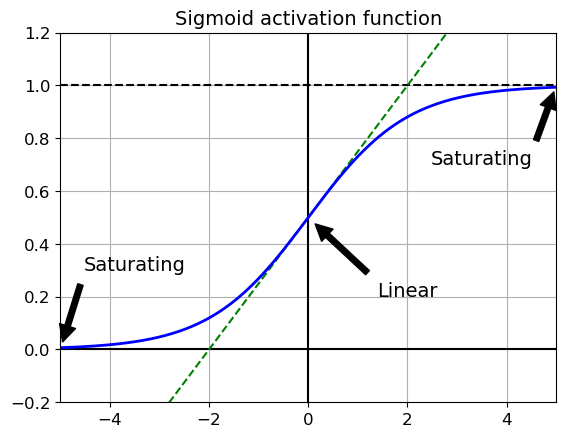

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

그래서 역전파가 진행될 때 사실상 신경망으로 전파할 그레이디언트가 거의 없고 조금 있는 그레이디언트는 최상위층부터 진행되며 점점 약해져서 아래쪽 층에는 아무것도 도달하지 않게 된다.

### 글로럿과 He 초기화

적절한 신호가 흐르기 위해서는 각 층의 출력 분산이 입력 분산화 같아야 한다. 역방향에서도 층을 통과하기 전과 후의 그레이디언트 분산이 동일해야 한다. 사실 층의 입력과 출력 연결 개수(fan-in, fan-out)가 같지 않다면 이 두 가지를 보장할 수 없다. 글로럿과 벤지오는 각 층의 연결 가중치를 무작위로 초기화하여 실전에서 잘 작동하는 것이 입증된 대안을 제시했다. __세이비어 초기화__ 또는 __글로럿 초기화__ 라고 한다. 조금 변형하여 __르쿤 초기화__ 전략으로 바꿀 수 있다. 그리고 ReLU 활성화 함수에 대한 초기화 전략은 __He 초기화__ 라고 부른다.

### 수렴하지 않는 활성화 함수

글로럿과 벤지오의 2010년 논문으로 얻은 통찰은 활성화 함수를 잘못 선택하면 그레이디언트 소실이나 폭주로 이어질 수 있다는 것이다. 그전에는 대부분 생물학적 뉴런의 방식과 비슷한 시그모이드 활성화 함수가 최선이라 생각했지만, 다른 활성화 함수가 심층 신경망에서 훨씬 더 잘 작동한다는 사실이 밝혀졌다. 특히 ReLU 활성화 함수는 특정 양숫값에 수렴하지 않고 계산이 빠르다는 큰 장점이 있다.  
하지만 ReLU 함수는 죽은 ReLU(Dying ReLU)라는 문제가 있다. 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는 현상을 말한다. 특히 큰 학습률에서는 신경망의 뉴런 절반이 죽어 있기도 한다. 뉴런의 가중치가 바뀌어 훈련 세트에 있는 모든 샘플에 대해 입력의 가중치 합이 음수가 되면 뉴런이 죽게 된다. 가중치 합이 음수이면 ReLU 함수의 그레이디언트가 0이 되어 경사 하강법이 작동하지 않는다.

이 문제를 해결하기 위해 __LeakyReLU__ 같은 변종 ReLU함수를 사용한다. LeakyReLU(z) = max(az, z)이다. 여기서 a는 이 함수가 새는(leaky) 정도를 결정한다. z<0일 의 기울기가 새는 정도이며 일반적으로 0.01로 설정한다. 이 작은 기울기가 뉴런이 절대 죽지 않게 만든다(혼수상태에 들어갈 수는 있다). [Bing Xu et al.."Empirical Evaluation of Rectified Activations in Convolutional Network," arXiv preptint arXiv:1505.00853(2015)에서 LeakyReLU가 항상 ReLU보다 성능이 높나는 사실이 확인되었다. 이 논문에서는 a를 무작위로 선택하고 테스트시에 평균을 사용하는 RReLU와 a가 훈련하는 동안 학습되는 PReLU도 평가했다. RReLU는 과대적합 위험을 줄이는 규제의 역할을 하는 것처럼 보였으며, PReLU는 대규모 이미지 데이터셋에서는 ReLU보다 성능이 크게 앞섰지만, 소규모 데이터 셋에서는 훈련 세트에 과대적합될 위험이 있다. 아래는 LeakyReLu 활성화 함수이다.

In [4]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

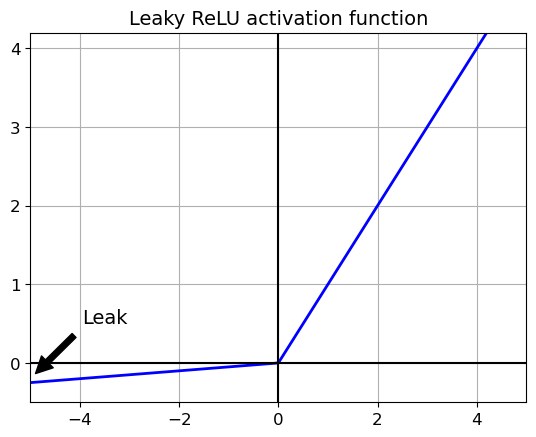

In [5]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

툐르크-아크네 클레베르트 등의 2015년 논문에서 제안된 ELU라는 새로운 활성화 함수는 다른 모든 ReLU 변종의 성능을 앞질렀다. 그래프는 다음과 같다.

In [6]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

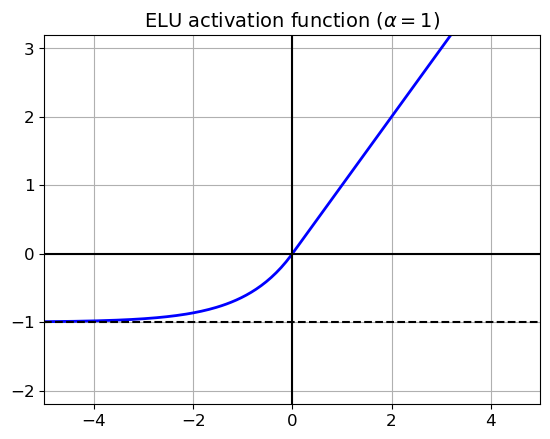

In [7]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

ELU 활성화 함수의 단점은 ReLU와 그 변종들보다 계산이 느리다는 것이다. 사실 훈련동안에는 수렴 속도가 빨라서 느린 계산이 상쇄되지만 테스트 시에는 ELU를 사용한 네트워크가 ReLU를 사용한 네트워크보다 느리다.  
권터 클람바우어는 2017년 논문에서 SELU 활성화 함수를 소개했다. ELU 활성화 함수의 변종으로 스케일이 조정되었으며 훈련동안 각 층의 출력 평균을 0, 표준편차를 1로 유지하는 경향이 있어 그레이디언트 소실과 폭주 문제를 막는다. 하지만 이 자기 정규화가 일어나기 위해서는 다음 조건이 필요하다.  
1. 입력 특성이 표준화(평균0, 표준편차1)되어야 한다.
2. 모든 은닉층의 가중치는 르쿤 정규분포 초기화로 초기화되어야 한다.
3. 네트워크는 일렬로 쌓은 층으로 구성되어야 한다. 순환 신경망이나 스킵 연결과 같은 순차적이지 않은 구조에선 자기 정규화가 보장되지 않는다.

아래는 SELU 활성화 함수이다.

In [8]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [9]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

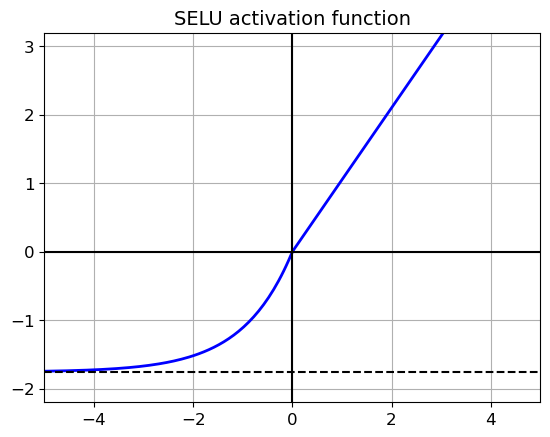

In [10]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

심층 신경망의 은닉층에 사용하는 활성화 함수의 일반적인 성능(네트워크기 선형이라 가정)  
SELU > ELU > LeakyReLU >= ReLU의 변종 > ReLU > tanh > sigmoid

### 배치 정규화

ELU(혹은 다른 ReLU 변종)과 He 초기화를 함께 사용하면 그레이디언트 소실, 폭주 문제를 크게 감소시킬 수 있지만 완전하진 않다. __배치 정규화__ 가 그레이디언트 소실, 폭주 문제를 해결하기 위한 또 다른 수단이다.  
이 기법은 각 측에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가한다. 단순하게 입력을 원점에 맞추고 정규화한 다음 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킨다. 하나는 스케일 조정에, 다른 하나는 이동에 사용한다. 많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 표준화할 필요가 없다. 배치 정규화 층이 이런 역학을 대신하기 때문이다.  

입력 데이터를 원점에 맞추고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야 한다. 훈련동안 배치 정규화는 입력을 정규화한 다음 스케일을 조정하고 이동시킨다. 하지만 테스트시에는 간단하지 않다. 샘플 하나에 대한 예측을 만들어야 하는데(테스트할 때 샘플이 하나씩 주입된다고 가정하기 때문) 이 경우 입력의 평균과 표준편차를 계산할 방법이 없다. 샘플의 배치를 사용하더라도 매주 작거나 독립 동일 분포(IID) 조건을 만족하지 않을 수 있다.  
한 가지 방법은 훈련이 끝난 후 전체 훈련 세트를 신경망에 통과시켜 배치 정규화 층의 각 입력에 대한 평균과 표준편차를 계산하는 것이다. 예측할 때 배치 입력 평균과 표준 편차로 이 최종 입력 평균과 표준편차를 대신 사용할 수 있다. 그러나 대부분 배치 정규화 구현은 층의 입력 평균과 표준편차의 이동 평균을 사용해 훈련하는 동안 최종 통계를 추정한다.

배치 정규화를 사용하면 그레이디언트 소실 문제가 크게 감소하여  tanh나 logistic 활성화 함수같은 수렴성 활성화 함수를 사용할 수 있다. 또 가중치 초기화에 네트워크가 훨씬 덜 민감해진다. 훨씬 큰 학습률을 사용하여 학습 과정의 속도를 크게 높일 수 있다.  
그 외에 추가적으로 배치 정규화는 규제와 같은 역할을 하여 다른 규제 기법의 필요성을 크게 줄여준다.  

하지만 배치 정규화는 모델의 복잡도를 키운다. 더구나 실행 시간 면에서도 손해이다. 다행히 훈련이 끝난 후에 이전 층과 배치 정규화 층을 합쳐 실행 속도 저하를 피할 수 있다.

#### 케라스로 배치 정규화 구현

은닉층의 활성화 함수 전이나 후에 BatchNormalization 층을 추가하면 된다. 아래는 각 은닉층 다음과 모델의 첫 번째 층으로 배치 정규화 층을 적용한다.

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

활성화 함수 전에 배치 정규화 층을 추가하려면 은닉층에서 활성화 함수를 지정하지 말고 배치 정규화 층 뒤에 별도의 층으로 추가해야 한다.

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

### 그레이디언트 클리핑

그레이디언트 폭주 문제를 완화하는 방법으로, 역전파될 때 일정 임곗값을 넘어서지 못하게 그레이디언트를 잘라낼 수 있다. 이를 __그레이디언트 클리핑__ 이라고 한다. 순황 신경망은 배치 정규화를 적용하기 어렵기 때문에 이 방법을 많이 사용한다. 다음과같이 옵티마이저를 만들 때 clipvalue와 clipnorm 매개변수를 지정하면 된다.

In [14]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [15]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전훈련된 층 재사용하기

아주 큰 규모의 DNN을 처음부터 새로 훈련하는 것보단 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망을 찾아보고 그 신경망의 하위층을 재사용하는 것이 좋다. 이를 __전이 학습__ 이라 한다.  
만약 사전 훈련된 이미지 분류 DNN을 사용한다면 이 모델에 맞는 크기의 이미지로 변경하는 전처리를 추가해야 한다. 일반적으로 전이 학습은 저수준 특성이 비슷한 입력에서 잘 작동한다. 그리고 보통 원본 모델의 출력층을 바꿔야 하며, 원본 모델의 상위 은닉층은 하위 은닉층보다 덜 유용하므로(새로운 작업에 유용한 고수준 특성이 원본 작업과 다르기 때문) 재사용할 층을 잘 선정해야 한다.  
재사용할 은닉층의 적절한 개수를 찾기 위해선 먼저 재사용하는 층을 모두 동결한다. 그다음 모델을 훈련하고 성능을 평가한다. 맨 위 한두개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조정하여 성능을 확인한다. 훈련 데이터가 많을수록 많은 층의 동결을 해제할 수 있다. 재사용 층의 동결을 해제할 떄는 학습률을 줄이는 것이 좋다. 기중치를 세밀하게 튜닝하는 데 도움이 된다. 좋은 성능을 낼 수 없고 훈련 데이터가 적다면 상위 은닝층을 제거하고 남은 은닉층을 다시 동결한다. 이런 식으로 반복한다. 만약 훈련 데이터가 아주 많다면 은닉층을 제거하는 대신 다른 것으로 바꾸거나 더 많은 은닉층을 추가할 수도 있다.

### 케라스를 사용한 전이 학습

상황: 8개의 클래스만 담겨있는 패션 MNIST 데이터셋으로 학습된 DNN 모델 A가 괜찮은(>90%) 정확도를 얻었다. 샌들과 셔츠 이미지를 구분하는 작업 B를 해결하기 위해 이진 분류기를 훈련하려 한다. 레이블된 데이터는 200개로 매우 적다. 이 데이터로 학습된 모델 B는 꽤 좋은 성능(>97%)을 냈지만 이진 분류 과제인 만큼 더 나은 성능을 원한다. 이 때 모델 A와 모델 B의 작업이 비슷하므로 모델 A로 전이학습 하려한다.

In [17]:
# 데이터 준비

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [18]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

In [20]:
# 모델 A 준비

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [21]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [22]:
# 모델 A 학습

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.5927 - accuracy: 0.8101 - val_loss: 0.3890 - val_accuracy: 0.8672
Epoch 2/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.3523 - accuracy: 0.8783 - val_loss: 0.3288 - val_accuracy: 0.8834
Epoch 3/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3012 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2894 - val_accuracy: 0.9016
Epoch 5/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.2835 - accuracy: 0.9021 - val_loss: 0.2771 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.2729 - accuracy: 0.9063 - val_loss: 0.2736 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.2642 - accuracy: 0.9091 - val_loss: 0.2718 - val_accuracy

In [23]:
# 모델 A 저장

model_A.save("my_model_A.h5")

In [24]:
# 모델 B 준비

model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [26]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [27]:
# 모델 B 학습

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 57ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6312 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 30ms/step - loss: 0.5692 - accuracy: 0.7500 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 29ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 25ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 27ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3020 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 25ms/step - loss: 0.2801 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [28]:
# 모델 A를 불러와 모델 B에 합치기
# 모델 A의 출력층만 제외하고 모든 층을 재사용한다.

model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
# 이 방법은 model_B_on_A를 훈련할 때 model_A도 영향을 받는다 이를 원하지 않는다면 아래처럼 한다(clone)

In [29]:
# 다른 방법으로 합치기: clone으로 복제한 후 가중치 복사하는 방법
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [30]:
# 출력층이 랜덤하게 초기화되어 있으므로 처음 몇 번 동안 큰 오차를 만들어 큰 오차 그레이디언트가 재사용된 가중치를 망칠 수 있다.
# 따라서 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 가중치를 학습할 시간을 줘야 한다.
# 이를 위해 trainable 속성을 False로 지정하고 모델을 컴파일한다.
# 동결하거나 동결을 해제한 후 반드시 모델을 컴파일 해야한다.
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [31]:
# 동결한 채로 학습하기

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 51ms/step - loss: 0.2676 - accuracy: 0.9400 - val_loss: 0.2815 - val_accuracy: 0.9260
Epoch 2/4
7/7 [==============================] - 0s 29ms/step - loss: 0.2577 - accuracy: 0.9400 - val_loss: 0.2718 - val_accuracy: 0.9290
Epoch 3/4
7/7 [==============================] - 0s 25ms/step - loss: 0.2482 - accuracy: 0.9400 - val_loss: 0.2629 - val_accuracy: 0.9320
Epoch 4/4
7/7 [==============================] - 0s 24ms/step - loss: 0.2396 - accuracy: 0.9400 - val_loss: 0.2546 - val_accuracy: 0.9371


In [32]:
# 동결을 해제하기

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [33]:
# 다시 학습하기
# 동결을 해제한 후엔 학습률을 낮춰 가중치가 망가지는 것을 막는 것이 좋다.

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 54ms/step - loss: 0.2142 - accuracy: 0.9450 - val_loss: 0.2056 - val_accuracy: 0.9625
Epoch 2/16
7/7 [==============================] - 0s 31ms/step - loss: 0.1710 - accuracy: 0.9550 - val_loss: 0.1726 - val_accuracy: 0.9706
Epoch 3/16
7/7 [==============================] - 0s 28ms/step - loss: 0.1415 - accuracy: 0.9650 - val_loss: 0.1496 - val_accuracy: 0.9797
Epoch 4/16
7/7 [==============================] - 0s 26ms/step - loss: 0.1202 - accuracy: 0.9800 - val_loss: 0.1328 - val_accuracy: 0.9817
Epoch 5/16
7/7 [==============================] - 0s 26ms/step - loss: 0.1049 - accuracy: 0.9900 - val_loss: 0.1202 - val_accuracy: 0.9838
Epoch 6/16
7/7 [==============================] - 0s 26ms/step - loss: 0.0931 - accuracy: 0.9950 - val_loss: 0.1103 - val_accuracy: 0.9858
Epoch 7/16
7/7 [==============================] - 0s 26ms/step - loss: 0.0838 - accuracy: 0.9950 - val_loss: 0.1021 - val_accuracy: 0.9858
Epoch 8/16
7/7 [===========

In [34]:
# 모델 B 성능

model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408281922340393, 0.9704999923706055]

In [35]:
# 모델 A를 전이학습한 모델 B 성능

model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.0561 - accuracy: 0.9940


[0.056094713509082794, 0.9940000176429749]

In [36]:
# 둘의 성능차이

(100 - 97.05) / (100 - 99.40)

4.916666666666718

사실 여기에는 높은 성능을 가진 모델을 찾기까지 여러 가지 설정을 시도한 과정이 포함되어 있지 않다. 실제로 위의 예에서 타깃 클래스나 랜덤 초깃값을 바꾸면 성능이 떨어질 것이다. 더 나빠질 수도 있다.  
전이 학습은 작은 완전 연결 네트워크에서는 잘 작동하지 않는다. 작은 네트워크는 패턴 수를 적게 학습하고 완전 연결 네트워크는 특정 패턴을 학습하기 때문일 것이다. 전이 학습은 좀 더 일반적인 특성을 감지하는 경향이 있는 심층 합성곱 신경망에서 잘 작동한다.

### 비지도 사전훈련

레이블된 훈련 데이터가 많지 않은 복잡한 문제가 있을 때 비슷한 작업에 대해 훈련된 모델을 찾을 수 없고, 더 많은 레이블된 훈련 데이터를 모으기도 어렵다면 __비지도 사전훈련__ 을 수행할 수 있다. 오토인코더나 GAN같은 비지도 학습 모델로 레이블되지 않은 데이터를 훈련시키고 그 하위층을 재사용하여 지도 학습으로 최종 네트워크를 세밀하게 튜닝한다.

## 고속 옵티마이저

훈련 속도를 높기이 위해 연결 가중치에 좋은 초기화 전략 적용하기, 좋은 활성화 함수 사용하기, 배치 정규화, 사전훈련된 네트워크 재활용하기가 가능함을 위에서 알 수 있다. 또다른 방법으로 표준적인 경사 하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수 있다. 모멘텀 최적화, 네스테로프 가속 경사, AdaGrad, RMSProp, Adam, Nadan 옵티마이저가 있다.

### 모멘텀 최적화

표준적인 경사 하강법이 경사면을 따라 일정한 크기의 스텝으로 조금씩 내려가는 것과 달리, 완만한 경사를 따라 낙하하듯이 가중치에 대한 비용 함수의 그레이디언트에 학습률을 곰한 것을 바로 차감하여 가중치를 갱신한다. 측 그레이디언트를 가속도로 사용한다. 이 때 모멘텀이 너무 커지는 것을 막기 위해 모멘텀이라는 새로운 하이퍼파라미터를 사용한다. 종단 속도와 같은 효과를 낸다.  
모멘텀 최적화는 경사 하강법보다 더 빠르게 평편한 지역을 탈출하며 좁고 긴 골짜기에서 바닥에 점점 더 빠르게 내려간다. 또한 지역 최적점을 건너뛰도록 하는 데도 도움이 된다.

In [ ]:
# 모멘텀 최적화 코드
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### 네스테로프 가속 경사

모멘텀 최적화의 변중이다. 기본 모멘텀 최적화보다 거의 항상 더 빠르다. 현재 위치보다 모멘텀의 방향으로 조금 앞선 위치에서 비용 함수의 그레이디언트를 계산한다.

In [ ]:
# 네스테로프 가속 경사 코드
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad

이 알고리즘은 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다. 이를 적응적 학습률이라 부르며 전역 최적점 방향으로 더 곧장 가도록 갱신되는 데 도움이 된다. 선형 회귀 같은 간단한 작업에 효과적일 수 있다. 하지만 신경망을 훈련할 때 학습률이 너무 감소되어 일찍 멈추는 경우가 종종 있다.

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

### RMSProp

AdaGrab의 조기종료를 가장 최근 반복에서 비롯된 그레이디언트만 누적함으로써 해결한 알고리즘이다.

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam, AdaMax, Nadam

Adam은 모멘텀 최적화와 RMSProp의 아이디어를 합친 것이다.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

AdaMax는 Adam의 변종으로 Adam보다 더 안정적이다.

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Nadam은 Adam 옵티마이저에 네스페로프 기법을 더한 것이다. 종종 Adam보다 더 빠르게 수렴한다.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

위의 모든 최적화 기법은 1차 편미분(야코비안)에만 의존한다. 최적화 이론에는 2차 편미분(헤시안)을 기반으로 한 뛰어난 알고리즘들이 있지만, 이런 알고리즘은 심층 신경망에 적용하기 매우 어렵다. 하나의 출력마다 n개의 1차 편미분이 아닌 n^2개의 2차 편미분을 계산해야 하기 때문이다(n은 파라미터 수).

### 학습률 스케줄링

학습률이 너무 크면 훈련이 발산하고, 너무 작으면 시간이 매우 오래 걸린다. 매우 작은 값부터 매우 큰 값까지 학습률을 지수적으로 증가시키면서 고정된 최적의 학습률을 찾을 수 있다. 하지만 이보다 처음엔 큰 학습률을 사용하고 나중엔 작은 학습률을 사용하는 것이 더 빠를 수 있다. 훈련하는 동안 학습률을 감소시키는 전략은 여러 가지가 있다. 이런 전략을 __학습 스케줄__ 이라 한다. 다음의 학습 스케줄이 널리 사용된다.

거듭제곱 기반 스케줄링, 지수 기반 스케줄링, 구간별 고정 스케줄링, 성능 기반 스케줄링, 1사이클 스케줄링

## 규제를 사용해 과대적합 피하기

수많은 파라미터는 대규모의 복잡한 데이터셋을 학습할 수 있게 해주지만 과대적합되기도 쉽게 만든다. 이를 규제로 해결할 수 있다. 조기종료와 배치 정규화는 훌륭한 규제 방법이다. 지금은 l1과 l2규제, 드롭아웃, 맥스-노름 규제를 알아본다.

### l1과 l2규제

신경망의 연결 가중치를 제한하기 위해 l1 규제를 사용하거나, 희소 모델을 만들기 위해 l1 규제를 사용할 수 있다.

In [37]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

일반적으로 네트워크의 모든 은닉층에 동일한 활성화 함수, 동일한 초기화 전략을 용하거나 모든 층에 동일한 규제를 적용하기 때문에 반복문을 사용하거나 파이썬의 functools.partial() 함수를 사용할 수 있다.

In [39]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [40]:
# 일일이 지정하기
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 6ms/step - loss: 1.5955 - accuracy: 0.8123 - val_loss: 0.7136 - val_accuracy: 0.8344
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7145 - accuracy: 0.8293 - val_loss: 0.6785 - val_accuracy: 0.8376


In [41]:
# 함수 사용하기
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 1.6780 - accuracy: 0.8128 - val_loss: 0.7205 - val_accuracy: 0.8334
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7201 - accuracy: 0.8282 - val_loss: 0.6846 - val_accuracy: 0.8392


### 드롭아웃

출력 뉴런을 제외한 모든 뉴런이 드롭아웃 비율 p를 갖는다. 이 p만큼의 확률로 해당 뉴런은 일회성으로 학습에서 제외된다. 학습을 마치면 가중치에 보존확률 1-p를 곱해야 한다. 훈련때는 드롭아웃된 뉴런만큼 적은 입력을 받았지만 테스트 동안엔 모든 뉴런이 사용되기 때문이다.

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 7ms/step - loss: 0.5659 - accuracy: 0.8045 - val_loss: 0.3653 - val_accuracy: 0.8642
Epoch 2/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4197 - accuracy: 0.8475 - val_loss: 0.3498 - val_accuracy: 0.8706


#### 몬테 카를로 드롭이웃

훈련된 드롭아웃 모델을 재훈련하기 않고 성능을 향상시키는 방법이다. 드롭아웃으로 만든 예측을 평균하면 일반적으로 드롭아웃 없이 예측한 하나의 결과보다 더 안정적이다.

In [44]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [45]:
# 드롭아웃을 끄고 패션 MNIST 테스트 세트에 있는 첫 번째 샘플의 모델을 예측
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 112ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.09, 0.  , 0.84]],
      dtype=float32)

In [46]:
# 드롭아웃을 활성화했을 때
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.19, 0.  , 0.78]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.05, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.  , 0.28, 0.  , 0.44]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.06, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.07, 0.  , 0.74]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.47, 0.  , 0.07, 0.  , 0.46]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.69, 0.  , 0.27]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.3 , 0.  , 0.69]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.13, 0.  , 0.86]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.02, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.17, 0.  , 0.63]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.  , 0.55, 0.  , 0.18]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.37, 0.  , 0

In [47]:
# 드롭아웃 활성화시 결과를 평균 내면
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.16, 0.  , 0.71]],
      dtype=float32)

In [48]:
y_pred = np.argmax(y_proba, axis=1)

In [49]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8549

모델이 훈련하는 동안 다르게 착동하는(BatchNormalization 같은) 층을 가지고 있다면 앞에서처럼 훈련 모드를 강제로 설정하면 안 된다. 대신 Dropout 층을 MCDropout 클래스로 바꿔야 한다.

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

### 맥스-노름 규제

각각의 뉴런에 대해 입력의 연결 가중치가 그것의 l2노름이 맥스-노름 하이퍼파라미터 이하가 되도록 제한한다.

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))